# Séries temporais

<b>Sumário</b>

- Exemplo de série temporal
- Índice com datas
- Agrupamento por intervalo de data e agregação
- Visualizando séries temporais
- Visualizando séries temporais com Pandas
- Visualizando séries temporais com Sktime
- Filtro por intervalo de data
- Janelas de tempos com shift
- Séries temporais como regressão supervisionada
    - Média móvel
    - Random walk
    - Gradient boosting
    - Gradient boosting com exôgenea 
    - Gradient boosting com variáveis temporais
    - Mudando a granuralidade
- Horizonte de previsão com Sktime
- Modelagem com Sktime
    - Auto ARIMA
    - Exponencial Smoothing
- Modelos do Sklearn com Sktime
    - Gradient Boosting
- Divisão de treino e teste com Sktime

In [1]:
# libraries

## data
import datetime

## data structure
import numpy as np
import pandas as pd

## ead
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

## preprocessing
from sktime.forecasting.compose import make_reduction

## train test split
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split

## sktime models
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
## sklearn regressor models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
## LightGBM
from lightgbm import LGBMRegressor

## feature selection
from sklearn.feature_selection import SelectKBest, r_regression

## forecasting horizon 
from sktime.forecasting.base import ForecastingHorizon

## metrics
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
)

## Exemplo de série temporal

Vejamos um exemplo de conjunto de dados com séries temporais.

In [2]:
df = pd.read_csv('../datasets/sales/train.csv')
df = df[['date', 'family', 'onpromotion', 'sales']]
df.head(3)

,date,family,onpromotion,sales
0,2013-01-01,AUTOMOTIVE,0,0.0
1,2013-01-01,BABY CARE,0,0.0
2,2013-01-01,BEAUTY,0,0.0


Queremos prever o número de vendas por família em uma data futura, dado a família e o número de produtos que está em promoção.

A diferença é que a coluna "date" requer um tratamento especial por ser data.

## Índice com data

In [3]:
# convertendo a coluna em date
df['date'] = pd.to_datetime(df['date'])
# colocando date no índice
df.index = df['date']
df.drop('date', axis=1, inplace=True)

Por simplicidade, vamos considerar apenas a família de carnes:

In [4]:
df = df[df['family'] == 'MEATS'].copy()
df.drop('family', axis=1, inplace=True)
df.head(3)

,onpromotion,sales
date,,
2013-01-01,0,0.0
2013-01-01,0,0.0
2013-01-01,0,0.0


## Agrupamento por intervalo de data e agregação

Observe que há dias com mais de um registro, vamos agrupar por dia agregando por soma.

In [5]:
df = df.groupby(df.index.floor('d')).agg(
    {'onpromotion': 'sum', 'sales': 'sum'})
df.head()

,onpromotion,sales
date,,
2013-01-01,0,110.801000
2013-01-02,0,20871.464028
2013-01-03,0,16597.398113
2013-01-04,0,21625.963055
2013-01-05,0,20879.091050


## Visualizando séries temporais com Pandas

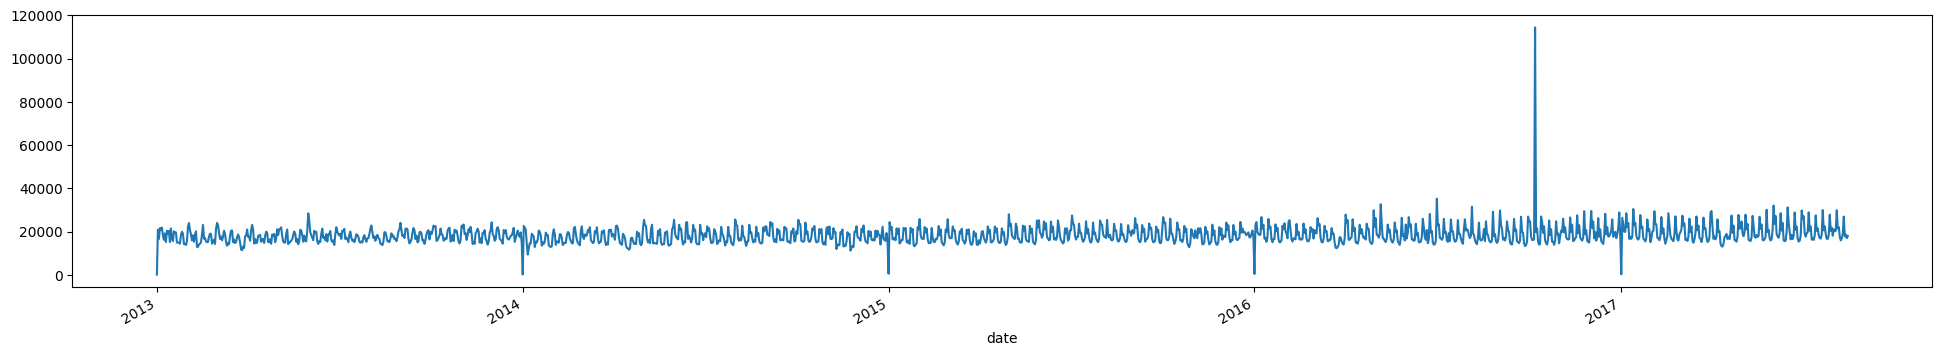

In [6]:
# visualizando o número de vendas
# com pandas
plt.figure(figsize=(24,4))
df['sales'].plot()
plt.show()

## Visualizando séries temporais com Sktime

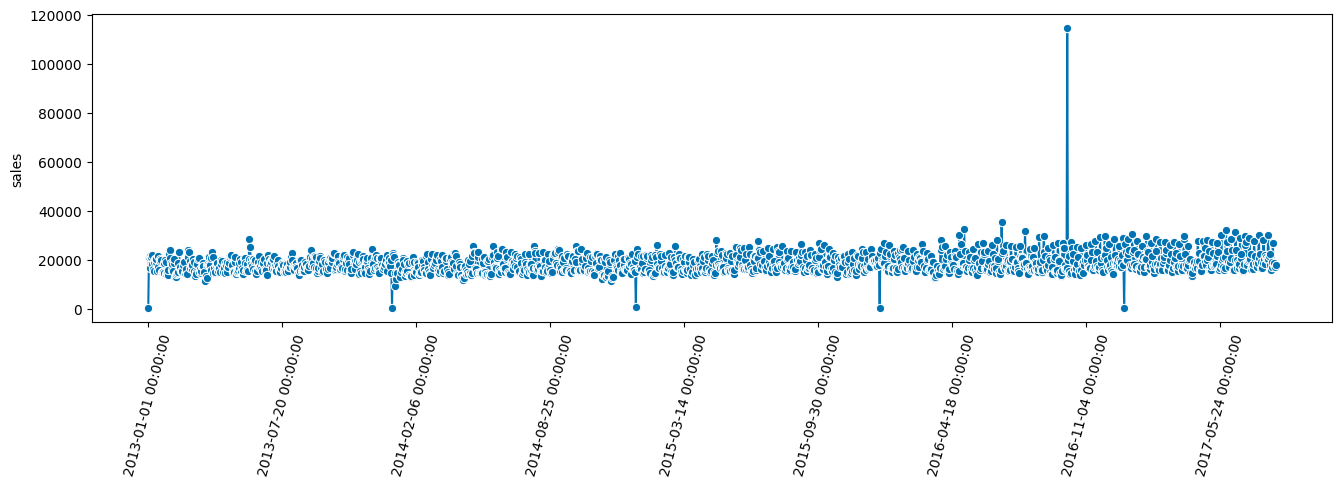

In [7]:
# visualizando o número de vendas
# com sktime
plot_series(df['sales'])
plt.xticks(rotation=75)
plt.show()

## Filtro por intervalo de data

Olhando um pouco melhor para o ano de 2014.

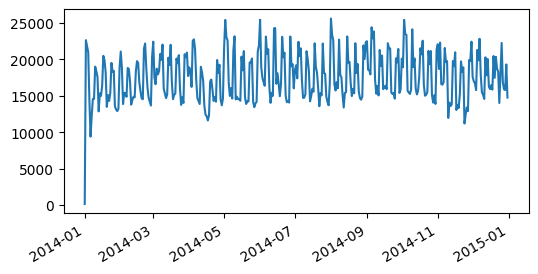

In [8]:
date_interval = df.index.to_series().between('2014-01-01', '2014-12-31')
df[date_interval]['sales'].plot(figsize=(6,3))
plt.show()

## Shift (janela de 20 dias)

In [9]:
shift_df = pd.DataFrame()
shift_df['onpromotion'] = df['onpromotion'].copy()
for i in range(21):
    if i==0: shift_df['t'] = df['sales']
    else: shift_df[f't-{i}'] = df['sales'].shift(i)
        
shift_df.dropna(inplace=True)
shift_df.reset_index(inplace=True)
shift_df.rename(columns={"index": "date"}, inplace=True)
shift_df.head(3)

,date,onpromotion,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,...,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20
0,2013-01-21,0,14964.118040,19616.94404,19438.808995,20140.309014,15596.239996,16758.846960,21466.086959,15157.171045,...,15144.950044,19139.782952,16200.319985,18314.175078,21880.005115,20879.091050,21625.963055,16597.398113,20871.464028,110.801000
1,2013-01-22,0,14906.880980,14964.11804,19616.944040,19438.808995,20140.309014,15596.239996,16758.846960,21466.086959,...,20400.725070,15144.950044,19139.782952,16200.319985,18314.175078,21880.005115,20879.091050,21625.963055,16597.398113,20871.464028
2,2013-01-23,0,14830.374015,14906.88098,14964.118040,19616.944040,19438.808995,20140.309014,15596.239996,16758.846960,...,19029.047018,20400.725070,15144.950044,19139.782952,16200.319985,18314.175078,21880.005115,20879.091050,21625.963055,16597.398113


## Regressão para série temporais (janela de 20 dias)

### Random walk

In [10]:
diffs= []
for i in range(1,19):
    diffs.append((shift_df[f't-{i+1}'] - shift_df[f't-{i}']).mean())
np.mean(diffs)

-1.1358925657051342

In [11]:
np.std(diffs)

2.5759339972441744

In [12]:
# features and target
X = shift_df.drop(['onpromotion','date','t'], axis=1)
y = shift_df['t']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42)

# compute walk
walk = X_test['t-1'].map(lambda x: x + np.random.normal(-1.136, 2.576))

# predict
y_pred = walk

# evaluate
mean_absolute_error(y_test, y_pred)

2914.0257126711153

In [13]:
# features and target
X = shift_df.drop(['onpromotion','date','t'], axis=1)
y = shift_df['t']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42)

# predict
y_pred = X_test['t-1']

# evaluate
mean_absolute_error(y_test, y_pred)

2913.8602860887017

### Média móvel

In [14]:
# features and target
X = shift_df.drop(['onpromotion','date','t'], axis=1)
y = shift_df['t']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42)

# predict
y_pred = X_test.T.mean()

# evaluate
mean_absolute_error(y_test, y_pred)

3098.465812647176

### Tunando média móvel

In [15]:
best_mae = 100000000
best_n = -1
for n in range(1,21):
    y_temp = X_train.iloc[:,0:n].T.mean()
    actual_mae = mean_absolute_error(y_temp, y_train)
    if actual_mae < best_mae:
        best_mae = actual_mae
        best_n = n
print("best n:", n)
print("best mae:", best_mae)

best n: 20
best mae: 2886.047820466176


### Gradient boosting

Podemos então usar os 20 dias anteriores para prever o dia de hoje (tempo t).

In [16]:
# features and target
X = shift_df.drop(['onpromotion','date','t'], axis=1)
y = shift_df['t']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42)

# model
model = GradientBoostingRegressor()

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mean_absolute_error(y_test, y_pred)

1583.7381688935932

## Variáveis exôgenas (promoção)

In [17]:
# features and target
X = shift_df.drop(['date','t'], axis=1)
y = shift_df['t']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42)

# model
model = GradientBoostingRegressor()

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mean_absolute_error(y_test, y_pred)

1537.663367154652

## Variáveis de data

In [18]:
shift_df['month'] = shift_df['date'].map(lambda x: x.month)
shift_df['year'] = shift_df['date'].map(lambda x: x.year)
# use feriados, bimestres, semestres, datas especiais, etc...

In [19]:
month_dummies = pd.get_dummies(
    shift_df['month'], drop_first=True, prefix='month')
year_dummies = pd.get_dummies(
    shift_df['year'], drop_first=True, prefix='year'
)
shift_df = pd.concat([shift_df,month_dummies,year_dummies],axis=1)

In [20]:
# features and target
X = shift_df.drop(['date','t'], axis=1)
y = shift_df['t']

# select K best
transformer = SelectKBest(r_regression, k=10)
X_new = transformer.fit_transform(X, y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_new,y,test_size=0.25,random_state=42)

# model
model = GradientBoostingRegressor()

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mean_absolute_error(y_test, y_pred)

1599.7461590210817

## Trocando a granularidade

Queremos agora estimar a venda de carnes para o próximo mês.

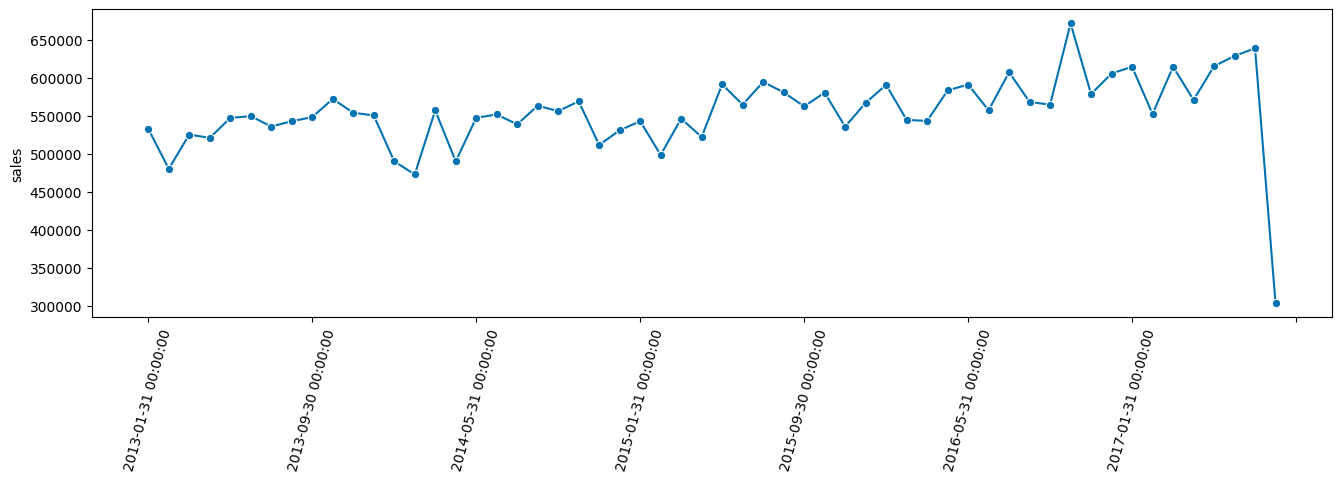

In [21]:
df = df.reset_index().resample('M',on='index').agg({
    'onpromotion': 'sum',
    'sales': 'sum'
})
plot_series(df['sales'])
plt.xticks(rotation=75)
plt.show()

Devido ao evento fora do padrão ao final do período de estudo, vamos considerar apenas dados de 2013 a 2016.

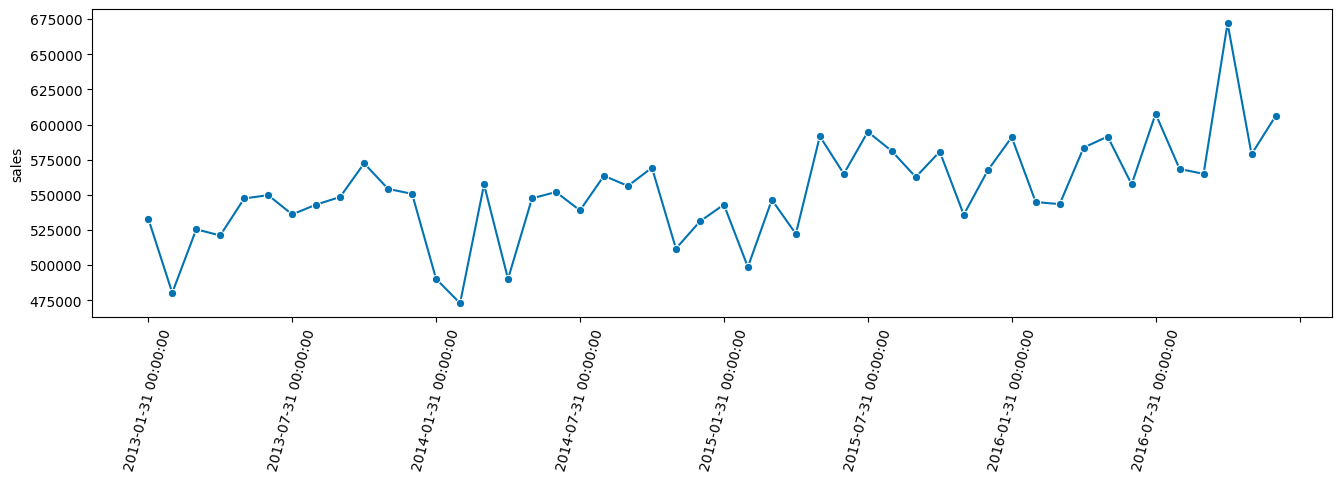

In [22]:
df = df[df.index<='2016-12-31']
plot_series(df['sales'])
plt.xticks(rotation=75)
plt.show()

In [23]:
shift_df = pd.DataFrame()
shift_df['onpromotion'] = df['onpromotion'].copy()
for i in range(21):
    if i==0: shift_df['t'] = df['sales']
    else: shift_df[f't-{i}'] = df['sales'].shift(i)
        
shift_df.dropna(inplace=True)
shift_df.reset_index(inplace=True)
shift_df.rename(columns={"index": "date"}, inplace=True)
shift_df.head(3)

,date,onpromotion,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,...,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20
0,2014-09-30,5967,556392.882056,563615.859131,538998.210029,552050.965793,547591.432618,490231.051883,557430.866019,472934.441401,...,572478.358950,548558.753157,543110.259599,536148.232708,549834.749027,547487.049146,521173.160301,525533.343087,480354.959696,533154.783758
1,2014-10-31,8159,569356.219706,556392.882056,563615.859131,538998.210029,552050.965793,547591.432618,490231.051883,557430.866019,...,554302.615027,572478.358950,548558.753157,543110.259599,536148.232708,549834.749027,547487.049146,521173.160301,525533.343087,480354.959696
2,2014-11-30,7836,511825.362873,569356.219706,556392.882056,563615.859131,538998.210029,552050.965793,547591.432618,490231.051883,...,550748.469551,554302.615027,572478.358950,548558.753157,543110.259599,536148.232708,549834.749027,547487.049146,521173.160301,525533.343087


In [24]:
# features and target
X = shift_df.drop(['date','t'], axis=1)
y = shift_df['t']

# select K best
transformer = SelectKBest(r_regression, k=10)
X_new = transformer.fit_transform(X, y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_new,y,test_size=0.25,random_state=42)

# model
model = GradientBoostingRegressor()

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mean_absolute_error(y_test, y_pred)

35098.70453530417

## Previsão com Sktime

In [25]:
df = pd.DataFrame({
    'date': ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12',
             '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16',
             '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20',
             '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24',
             '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28',
             '2013-01-29', '2013-01-30'],
    'sales': [
        2,4,5,3,5,10,2,5,3,10,
        1,5,6,2,6,11,3,5,4,10,
        2,7,8,1,5,12,3,5,2,11
    ]
})
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.to_period('D')
df.set_index('date',inplace=True)
df.head(3)

,sales
date,
2013-01-01,2
2013-01-02,4
2013-01-03,5


In [26]:
fh = ForecastingHorizon(pd.PeriodIndex(
    pd.date_range('2013-01-21', periods=10, freq="D")),
    is_relative=False)
fh

ForecastingHorizon(['2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24',
             '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28',
             '2013-01-29', '2013-01-30'],
            dtype='period[D]', is_relative=False)

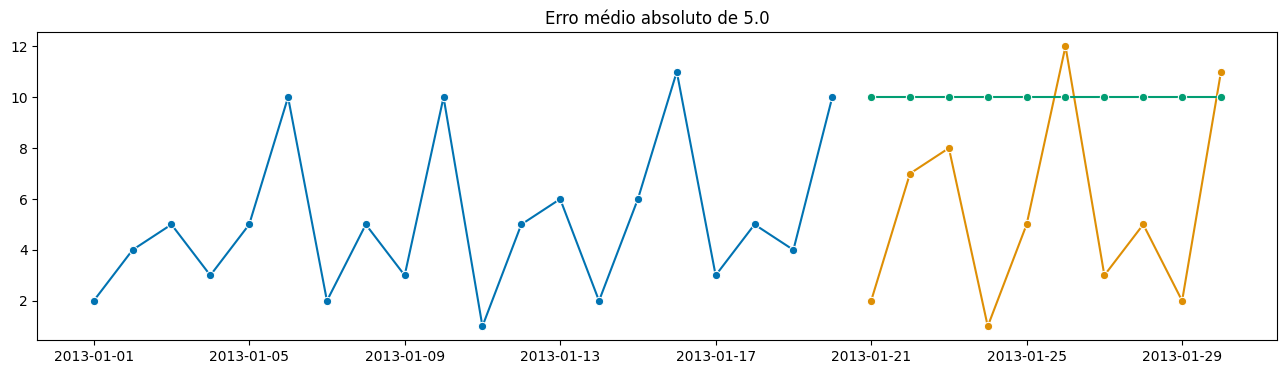

In [27]:
# train test split
y_train = df.iloc[:20,:]
y_test = df.iloc[20:,:]

# baseline with naive forecaster
forecaster = NaiveForecaster(window_length=5)

# fit model
forecaster.fit(y_train)

# get predictions
y_pred = forecaster.predict(fh)

# evaluate
mae = MeanAbsoluteError()
error = mae(y_pred, y_test)

# plot series
plot_series(y_train, y_test, y_pred)
plt.title(f"Erro médio absoluto de {error}")
plt.show()

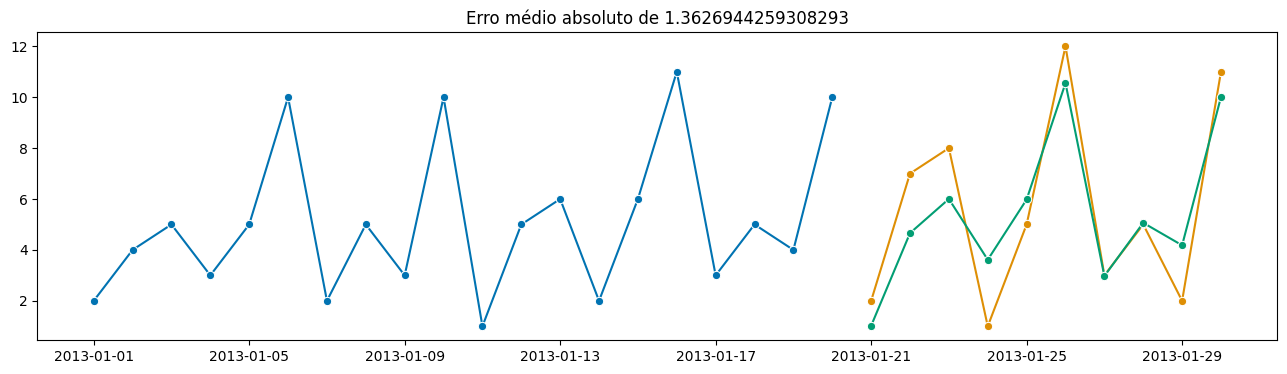

In [28]:
# get model
regressor = GradientBoostingRegressor()

# convert data to tabular and ajust model
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

# fit model
forecaster.fit(y_train)

# get predictions
y_pred = forecaster.predict(fh)

# evaluate
mae = MeanAbsoluteError()
error = mae(y_pred, y_test)

# plot series
plot_series(y_train, y_test, y_pred)
plt.title(f"Erro médio absoluto de {error}")
plt.show()

Estratégias de predição:
    
    - Recursiva (padrão), usa a última para previsão para prever a próxima
    - Direta, um modelo para cada componente do horizonte de previsão
    - Multi-output, um modelo para todo o horizonte de previsão

### AutoArima

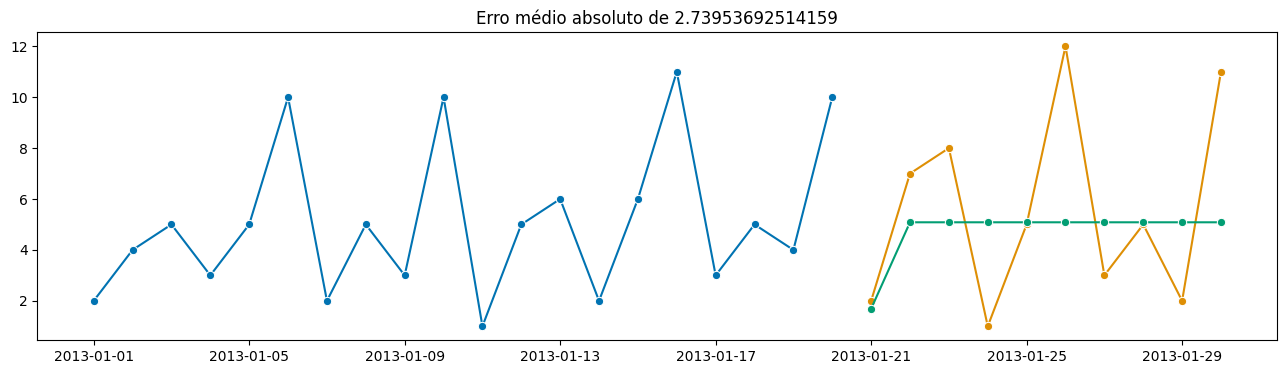

In [29]:
# model
forecaster = AutoARIMA(suppress_warnings=True)

# train
forecaster.fit(y_train)

# predict
y_pred = forecaster.predict(fh)

# evaluate
mae = MeanAbsoluteError()
error = mae(y_pred, y_test)

# plot series
plot_series(y_train, y_test, y_pred)
plt.title(f"Erro médio absoluto de {error}")
plt.show()

## Sktime com variáveis exôgeneas

In [30]:
df = pd.DataFrame({
    'date': ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12',
             '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16',
             '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20',
             '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24',
             '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28',
             '2013-01-29', '2013-01-30'],
    'sales': [
        2,4,5,3,5,10,2,5,3,10,
        1,5,6,2,6,11,3,5,4,10,
        2,7,8,1,5,12,3,5,2,11
    ],
    'onpromotion': [
        1,0,1,0,0,5,0,0,0,4,
        0,2,1,1,0,4,0,0,1,6,
        0,3,2,0,1,8,0,0,1,4
    ]
})
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.to_period('D')
df.set_index('date',inplace=True)
df.head(3)

,sales,onpromotion
date,,
2013-01-01,2,1
2013-01-02,4,0
2013-01-03,5,1


In [31]:
y_train = df[['sales']].iloc[:20,:] # endogeneous
X_train = df[['onpromotion']].iloc[:20,:] # exogeneous
y_test = df[['sales']].iloc[20:,:]
X_test = df[['onpromotion']].iloc[20:,:]

In [32]:
# outro jeito de declarar o horizonte de previsão
fh = np.arange(10) + 1

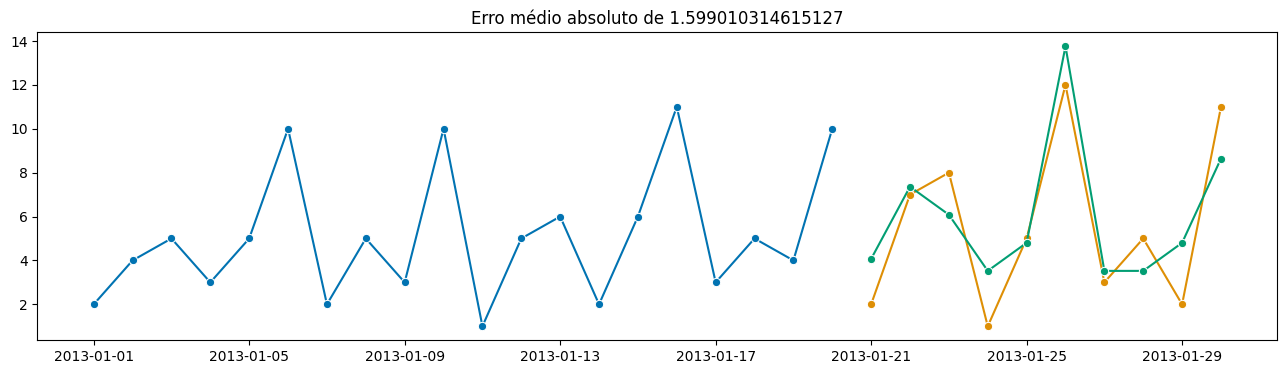

In [33]:
# model
forecaster = AutoARIMA(suppress_warnings=True)

# train
forecaster.fit(y_train, X_train)

# predict
y_pred = forecaster.predict(fh, X=X_test)

# evaluate
mae = MeanAbsoluteError()
error = mae(y_pred, y_test)

# plot series
plot_series(y_train, y_test, y_pred)
plt.title(f"Erro médio absoluto de {error}")
plt.show()

Apenas modelos que permitem ajuste em variáveis exônegeas são permitidos:

## Treino e teste com sktime

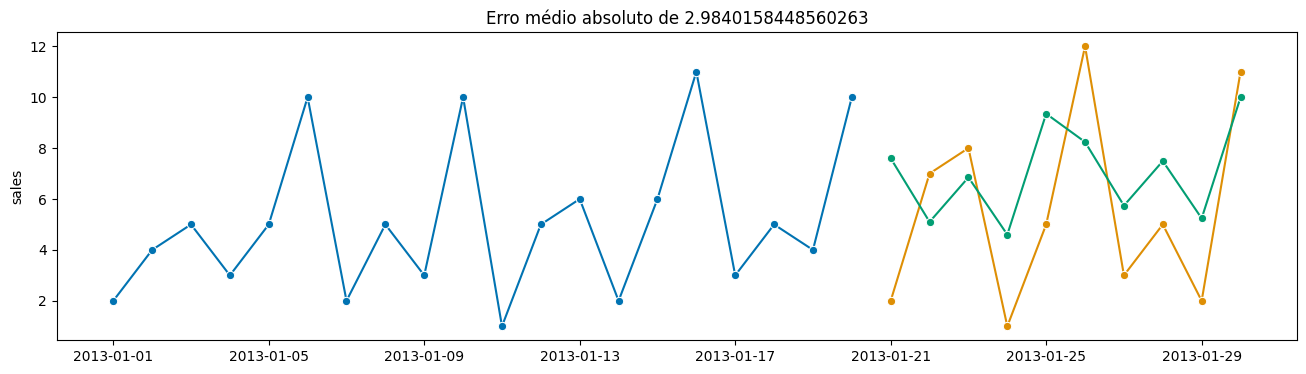

In [34]:
X, y = df.drop('sales',axis=1), df['sales']

y_train, y_test, X_train, X_test = temporal_train_test_split(
    y, X, fh=fh
)

forecaster = ExponentialSmoothing(
    trend='add', seasonal='add', sp=5
)

# train
forecaster.fit(y_train, X_train)

# predict
y_pred = forecaster.predict(fh, X=X_test)

# evaluate
mae = MeanAbsoluteError()
error = mae(y_pred, y_test)

# plot series
plot_series(y_train, y_test, y_pred)
plt.title(f"Erro médio absoluto de {error}")
plt.show()

### Todos os modelos

In [35]:
from sktime.registry import all_estimators
all_estimators('forecaster', as_dataframe=True)

,name,estimator
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,Croston,<class 'sktime.forecasting.croston.Croston'>


## Referências

- https://www.youtube.com/watch?v=GbRfbXHXUKM
- https://www.kaggle.com/competitions/store-sales-time-series-forecasting